Cross Validation 4

size = 72684

test size 4k+

epoch-3

apply sigmoid (prediction probabilities are logits)

groups-9

target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

threshold-tuning = yes

df_2k = df[(df['Rating'] >= 4.0) & (df['Maximum_Installs'] >= 20000)]

accuracy score : F1 score (micro) and ROC_AUC score

## 1. Setup

In [1]:
!pip install sentencepiece

In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 8.5 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 67.3 MB/s 
     |████████████████████████████████| 596 kB 74.1 MB/s 
     |████████████████████████████████| 6.5 MB 55.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


--- reconnect --

In [3]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


## 2. Load Dataset

In [5]:
## uploading csv files on drive (to avoid uploading on colab in every session)

from google.colab import drive
drive.mount("/content/drive/")

## drive path
train_path = "/content/drive/MyDrive/MetadataCSV/data_72684/CV_df_train_4.csv"
val_path = "/content/drive/MyDrive/MetadataCSV/data_72684/CV_df_val_4.csv"
test_path = "/content/drive/MyDrive/MetadataCSV/test_dataset.csv"

Mounted at /content/drive/


In [6]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path) 
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(58147, 23)
(14537, 23)
(4624, 23)


In [7]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Contacts,SMS,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length
0,Face Chat,com.facechat.live,Social,4.1,7306795,False,Enjoy chatting? Social and Video Chat on Face ...,https://sites.google.com/view/xender-chat-term...,0,1,...,0,0,1,1,0,0,1090,enjoy chatting? social and video chat on face ...,1025,197
1,Running - Calorie Counter,com.sdgcode.runningcaloriecounter,Health & Fitness,4.1,286133,False,"Running Counter - Calorie Counter app, your wa...",http://app.sdgcode.com/privacy-policy/,0,0,...,0,0,0,0,0,0,845,"running counter calorie counter app, your way ...",816,162


In [8]:
target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

In [9]:
# getting number of nonzeros in each column
df_train[target_list].astype(bool).sum(axis=0)

Camera         9235
Location       9267
Microphone     5441
Contacts       6312
Storage       28567
Phone          9060
SMS             273
Call_Log        183
Calendar       1037
dtype: int64

In [10]:
df_val[target_list].astype(bool).sum(axis=0)

Camera        2302
Location      2255
Microphone    1345
Contacts      1622
Storage       7041
Phone         2176
SMS             79
Call_Log        44
Calendar       258
dtype: int64

In [11]:
df_test[target_list].astype(bool).sum(axis=0)

Camera         745
Location       716
Microphone     436
Contacts       500
Storage       2402
Phone          652
SMS             11
Call_Log         6
Calendar        90
dtype: int64

## 3. XLNet Tokenizer - Preprocess Data

### 3.1. Tokenize

In [12]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [13]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [14]:
train_text_list = df_train['Clean_Description'].values
val_text_list = df_val['Clean_Description'].values
test_text_list = df_test['Clean_Description'].values

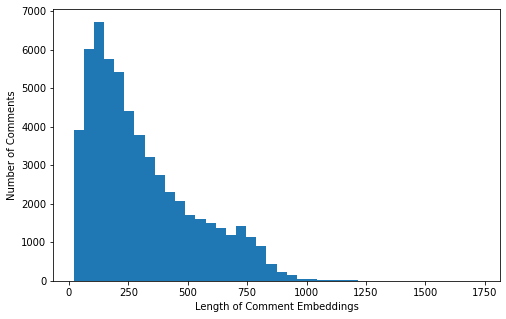

In [15]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

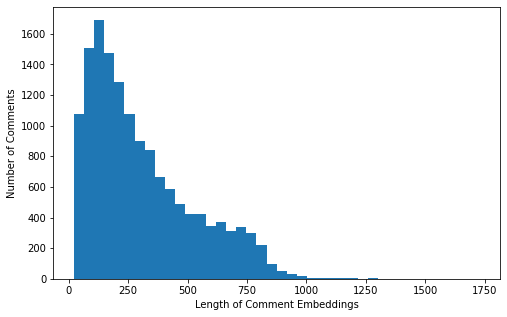

In [16]:
plot_sentence_embeddings_length(val_text_list, tokenizer)

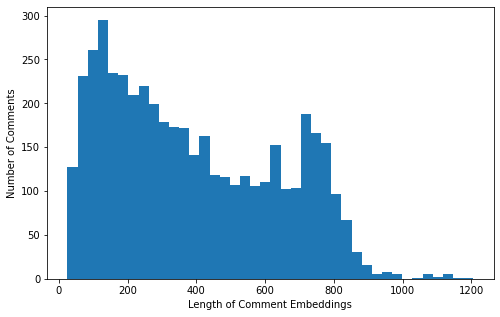

In [17]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [18]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [19]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[ 1991, 24028,    82, ...,     0,     0,     0],
       [  926,  2610,    17, ...,     0,     0,     0],
       [ 7956,    19,  9722, ...,  6463,     4,     3],
       ...,
       [17200, 12334, 21616, ...,     0,     0,     0],
       [  419,  3934,   419, ...,     0,     0,     0],
       [ 2040,   136,    27, ...,     9,     4,     3]])

In [20]:
# create input id tokens
val_input_ids = tokenize_inputs(val_text_list, tokenizer, num_embeddings=250)
val_input_ids

array([[31470,    23,    17, ...,     0,     0,     0],
       [   28,    66,  7647, ...,    66,     4,     3],
       [   33,    52,  5523, ...,    17,     4,     3],
       ...,
       [  373,  4160,    17, ...,     0,     0,     0],
       [ 1319,   235,    22, ...,     0,     0,     0],
       [  943,  3633,  1529, ...,    53,     4,     3]])

In [21]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[  108,    44,    41, ...,     0,     0,     0],
       [ 2039,    40,  8425, ...,     0,     0,     0],
       [   17, 12293,  2686, ...,   177,     4,     3],
       ...,
       [26941,   669,    17, ...,   751,     4,     3],
       [ 1184,  2387,  1603, ...,   181,     4,     3],
       [  113,   108,  4626, ...,  1304,     4,     3]])

### 3.2. Attention Masks

In [22]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
#train_attention_masks

In [23]:
# create attention masks
val_attention_masks = create_attn_masks(val_input_ids)
#val_attention_masks

In [24]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
#test_attention_masks

In [25]:
# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids.tolist()
df_train["masks"] = train_attention_masks

df_val["features"] = val_input_ids.tolist()
df_val["masks"] = val_attention_masks

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks

In [26]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Face Chat,com.facechat.live,Social,4.1,7306795,False,Enjoy chatting? Social and Video Chat on Face ...,https://sites.google.com/view/xender-chat-term...,0,1,...,1,1,0,0,1090,enjoy chatting? social and video chat on face ...,1025,197,"[1991, 24028, 82, 796, 21, 894, 6368, 31, 423,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Running - Calorie Counter,com.sdgcode.runningcaloriecounter,Health & Fitness,4.1,286133,False,"Running Counter - Calorie Counter app, your wa...",http://app.sdgcode.com/privacy-policy/,0,0,...,0,0,0,0,845,"running counter calorie counter app, your way ...",816,162,"[926, 2610, 17, 26048, 2610, 5523, 19, 73, 162...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [27]:
df_val.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Obstetrics & Gynaecology,com.andromo.dev706301.app837242,Education,4.4,36419,False,Obstetrics & Gynaecology application is mainly...,https://gist.githubusercontent.com/MedicoGuide...,0,0,...,0,0,0,0,152,obstetrics gynaecology application is mainly d...,150,33,"[31470, 23, 17, 3597, 597, 93, 17284, 1479, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,FordPass,com.ford.fordpass,Lifestyle,4.3,3064680,False,FordPass has so many ways to make your ownersh...,https://www.fordpass.com/content/ford_com/fp_a...,0,0,...,0,0,0,0,2462,fordpass has so many ways to make your ownersh...,2338,407,"[28, 66, 7647, 51, 102, 142, 1420, 22, 144, 73...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [28]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length,features,masks
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,1,0,0,0,901,if you are a poetry lover and did not find the...,876,191,"[108, 44, 41, 24, 7163, 11139, 21, 190, 50, 27...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,1,0,0,0,302,note from developer force close on froyo . fir...,284,70,"[2039, 40, 8425, 779, 474, 31, 17, 12803, 4333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [29]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [30]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [31]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [32]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

### 3.3. Train, Valid Split

In [33]:
X_train = df_train["features"].values.tolist() + df_acnet["features"].values.tolist() #+ df_test["features"].values.tolist()

train_masks = df_train["masks"].values.tolist() + df_acnet["masks"].values.tolist() #+ df_test["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_train = df_train[label_cols].values.tolist() + df_acnet[label_cols].values.tolist() #+ df_test[label_cols].values.tolist()

In [34]:
X_valid = df_val["features"].values.tolist()

valid_masks = df_val["masks"].values.tolist()

label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']
Y_valid = df_val[label_cols].values.tolist()

### 3.4. Create Dataloaders

In [35]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [36]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [37]:
# Function for class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    print(class_series)
    print(class_labels)

    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])
    #print(n_samples)
    #print(n_classes)

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    #return dict(zip(class_labels, class_weights))
    return class_weights

In [38]:
class_series = np.array(Y_train)
class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
print(class_wt)
class_wt = torch.tensor(class_wt)
print(class_wt)

[0.6992697473466705, 0.6914521877430665, 1.184091767559293, 0.9808639230604549, 0.22707551773568793, 0.7213744156190199, 13.645131729667812, 23.720031859816807, 5.800077904372383]
tensor([ 0.6993,  0.6915,  1.1841,  0.9809,  0.2271,  0.7214, 13.6451, 23.7200,
         5.8001])


## 4. XLNet Fine Tuning

### 4.1. Train our model

In [39]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch

      ##
      #mycode-start
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to(device)
      #mycode-end

      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
     
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### 4.2. XLNetForMultiLabelSequenceClassification

In [40]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
      class_wt = torch.tensor(class_wt)
      class_wt = class_wt.to('cuda')
      loss_fct = BCEWithLogitsLoss(pos_weight=class_wt)
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 4.3. Optimizer & Learning Rate Scheduler

In [41]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### 4.4. Training Loop

In [42]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_mod5.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.015268828662812586
Valid loss: 0.01333934104454077


Epoch:  33%|███▎      | 1/3 [2:22:29<4:44:59, 8549.83s/it]

Saving model at epoch 0 with validation loss of 0.01333934104454077


Train loss: 0.012740163527181048


Epoch:  67%|██████▋   | 2/3 [4:44:41<2:22:18, 8538.93s/it]

Valid loss: 0.013341173901974585


Train loss: 0.011345274429467166
Valid loss: 0.012563085589293166


Epoch: 100%|██████████| 3/3 [7:07:16<00:00, 8545.43s/it]

Saving model at epoch 2 with validation loss of 0.012563085589293166




Text(0.5, 1.0, 'Loss vs Number of Epochs')

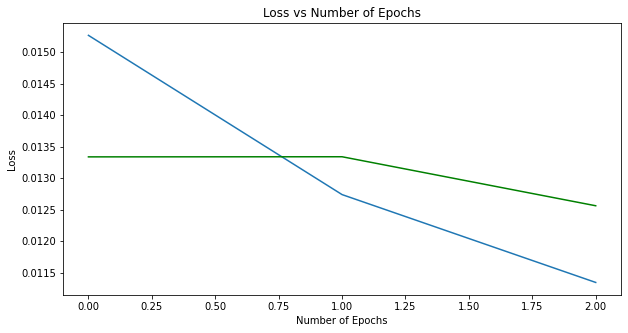

In [43]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## 5. Performance On Test Set

In [44]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [45]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[9.87494458e-03, 5.46512716e-02, 8.79350211e-03, ...,
        3.00719519e-04, 6.07205002e-05, 7.53704691e-04],
       [3.88547848e-03, 1.15142958e-02, 2.80537107e-03, ...,
        1.73164939e-04, 4.87353782e-06, 1.33343958e-04],
       [1.81062236e-01, 2.43285313e-01, 3.03993732e-01, ...,
        3.01551148e-02, 2.40480509e-02, 1.98093206e-01],
       ...,
       [6.19678497e-01, 3.16183388e-01, 5.53378582e-01, ...,
        1.36007015e-02, 9.78328884e-02, 1.83091536e-01],
       [8.96126556e-04, 9.75742340e-01, 9.85195994e-01, ...,
        2.56694875e-05, 1.01675003e-04, 3.87258753e-02],
       [4.75422526e-03, 1.29723400e-02, 4.23024669e-02, ...,
        5.36265899e-04, 3.43737520e-05, 2.22776740e-04]])

In [46]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_test['P_Camera'] = pred_probs[:,0]
df_test['P_Location'] = pred_probs[:,1]
df_test['P_Microphone'] = pred_probs[:,2]
df_test['P_Contacts'] = pred_probs[:,3]
df_test['P_Storage'] = pred_probs[:,4]
df_test['P_Phone'] = pred_probs[:,5]
df_test['P_SMS'] = pred_probs[:,6]
df_test['P_Call_Log'] = pred_probs[:,7]
df_test['P_Calendar'] = pred_probs[:,8]

In [47]:
df_test.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.009875,0.054651,0.008794,0.023875,0.161228,0.022690,0.000301,0.000061,0.000754
1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.003885,0.011514,0.002805,0.009822,0.040071,0.013808,0.000173,0.000005,0.000133


In [48]:
test_to_csv = df_test.reset_index()
test_to_csv.head(2)

,index,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,Urdu Poetry Offline,com.wikitech.UrduShayari,Entertainment,4.9,567189,False,If you are a poetry lover and did not find the...,https://sites.google.com/view/offlineurdupoetr...,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.009875,0.054651,0.008794,0.023875,0.161228,0.022690,0.000301,0.000061,0.000754
1,1,"53,000+ Famous Quotes Free",com.webworks.freequotes,Entertainment,4.8,293524,False,*Note from Developer: Force close on Froyo 2.2...,http://www.kappboom.com/tos.html,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.003885,0.011514,0.002805,0.009822,0.040071,0.013808,0.000173,0.000005,0.000133


In [49]:
true_l = df_test[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_test[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [50]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [51]:
np.save("true_labels.npy", true_labels)
np.save("predictions.npy", predictions)

In [52]:
predictions

array([[9.87494458e-03, 5.46512716e-02, 8.79350211e-03, ...,
        3.00719519e-04, 6.07205002e-05, 7.53704691e-04],
       [3.88547848e-03, 1.15142958e-02, 2.80537107e-03, ...,
        1.73164939e-04, 4.87353782e-06, 1.33343958e-04],
       [1.81062236e-01, 2.43285313e-01, 3.03993732e-01, ...,
        3.01551148e-02, 2.40480509e-02, 1.98093206e-01],
       ...,
       [6.19678497e-01, 3.16183388e-01, 5.53378582e-01, ...,
        1.36007015e-02, 9.78328884e-02, 1.83091536e-01],
       [8.96126556e-04, 9.75742340e-01, 9.85195994e-01, ...,
        2.56694875e-05, 1.01675003e-04, 3.87258753e-02],
       [4.75422526e-03, 1.29723400e-02, 4.23024669e-02, ...,
        5.36265899e-04, 3.43737520e-05, 2.22776740e-04]])

In [53]:
true_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 6. Threshold Calculation

In [54]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [55]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [56]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.242 with F-Score: 0.6832
permission  1
Length of sequence: 10000
Best Threshold: 0.2385 with F-Score: 0.5869
permission  2
Length of sequence: 10000
Best Threshold: 0.3809 with F-Score: 0.5947
permission  3
Length of sequence: 10000
Best Threshold: 0.291 with F-Score: 0.5223
permission  4
Length of sequence: 10000
Best Threshold: 0.1374 with F-Score: 0.7915
permission  5
Length of sequence: 10000
Best Threshold: 0.2595 with F-Score: 0.5411
permission  6
Length of sequence: 10000
Best Threshold: 0.8286 with F-Score: 0.125
permission  7
Length of sequence: 10000
Best Threshold: 0.9812 with F-Score: 0.5
permission  8
Length of sequence: 10000
Best Threshold: 0.3033 with F-Score: 0.3843
-------------------------------------
optimal threshold tuning for f-score
[0.242, 0.2385, 0.3809, 0.291, 0.1374, 0.2595, 0.8286, 0.9812, 0.3033]


In [57]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("predictions.npy")
  true_labels = np.load("true_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.1115 with G-Mean: 0.8434
FPR: 0.1439, TPR: 0.8309
permission  1
Best Threshold: 0.1325 with G-Mean: 0.7835
FPR: 0.2052, TPR: 0.7723
permission  2
Best Threshold: 0.1606 with G-Mean: 0.839
FPR: 0.1428, TPR: 0.8211
permission  3
Best Threshold: 0.1163 with G-Mean: 0.8026
FPR: 0.2144, TPR: 0.82
permission  4
Best Threshold: 0.174 with G-Mean: 0.7743
FPR: 0.2345, TPR: 0.7831
permission  5
Best Threshold: 0.078 with G-Mean: 0.7571
FPR: 0.3041, TPR: 0.8236
permission  6
Best Threshold: 0.0084 with G-Mean: 0.831
FPR: 0.2404, TPR: 0.9091
permission  7
Best Threshold: 0.073 with G-Mean: 0.9818
FPR: 0.0362, TPR: 1.0
permission  8
Best Threshold: 0.0587 with G-Mean: 0.85
FPR: 0.1873, TPR: 0.8889
-------------------------------------
ROC curve with G-mean threshold tuning
[0.1115, 0.1325, 0.1606, 0.1163, 0.174, 0.078, 0.0084, 0.073, 0.0587]


## 7. Performance Score

In [ ]:
#Fscore micro for different thresholds-

In [58]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [59]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f_at_1(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

   
    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [60]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.6832
  Location  : 0.5869
  Microphone: 0.5947
  Contacts  : 0.5223
  Storage   : 0.7915
  Phone     : 0.5411
  SMS       : 0.1250
  Call_Log  : 0.5000
  Calendar  : 0.3843

  Average F1 score: 0.5254


In [ ]:
#Fscore micro for different thresholds-

In [61]:
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [62]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f1micro_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0], average='micro')
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1], average='micro')
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2], average='micro')
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3], average='micro')
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4], average='micro')
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5], average='micro')
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6], average='micro')
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7], average='micro')
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8], average='micro')
    
   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [63]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/F1Mic_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.8951
  Location  : 0.8618
  Microphone: 0.9245
  Contacts  : 0.8888
  Storage   : 0.7710
  Phone     : 0.8635
  SMS       : 0.9970
  Call_Log  : 0.9991
  Calendar  : 0.9660

  Average F1 (micro) score: 0.9074


In [ ]:
#roc-auc score for different thresholds-

In [64]:
import numpy as np
#predictions = np.load("predictions.npy")
predictions = np.load("predictions.npy")
true_labels = np.load("true_labels.npy")

In [65]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_roc[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_roc[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_roc[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_roc[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_roc[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_roc[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_roc[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_roc[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_roc[8]


    acc[0] = roc_auc_score(labels[:, 0], preds_th[:, 0])
    acc[1] = roc_auc_score(labels[:, 1], preds_th[:, 1])
    acc[2] = roc_auc_score(labels[:, 2], preds_th[:, 2])
    acc[3] = roc_auc_score(labels[:, 3], preds_th[:, 3])
    acc[4] = roc_auc_score(labels[:, 4], preds_th[:, 4])
    acc[5] = roc_auc_score(labels[:, 5], preds_th[:, 5])
    acc[6] = roc_auc_score(labels[:, 6], preds_th[:, 6])
    acc[7] = roc_auc_score(labels[:, 7], preds_th[:, 7])
    acc[8] = roc_auc_score(labels[:, 8], preds_th[:, 8])
   

    #print(acc)
    return acc

In [66]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ROC_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8428
  Location  : 0.7822
  Microphone: 0.8392
  Contacts  : 0.8018
  Storage   : 0.7741
  Phone     : 0.7590
  SMS       : 0.7894
  Call_Log  : 0.9819
  Calendar  : 0.8453

  Average ROC_AUC score: 0.8240


# ACNET Performance

#### a) Data Preparation

In [67]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [68]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [69]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [70]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...


In [71]:
acnet_text_list = df_acnet['Clean_Description'].values

# create input id tokens
acnet_input_ids = tokenize_inputs(acnet_text_list, tokenizer, num_embeddings=250)

# create attention masks
acnet_attention_masks = create_attn_masks(acnet_input_ids)

# add input ids and attention masks to the dataframe
df_acnet["features"] = acnet_input_ids.tolist()
df_acnet["masks"] = acnet_attention_masks

In [72]:
df_acnet.head(2)

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description,features,masks
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...,"[5988, 27, 978, 28, 6073, 31769, 3116, 21, 102...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...,"[52, 5523, 12861, 573, 21584, 23, 4473, 18, 10...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### b) Get Predictions

In [73]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, df_acnet, num_labels, device="cuda", batch_size=32)
pred_probs

array([[2.09374372e-02, 9.06035677e-02, 9.24314186e-03, ...,
        4.92099114e-02, 5.75258816e-03, 1.95762701e-03],
       [1.87167808e-01, 2.78472215e-01, 1.90569803e-01, ...,
        8.93786669e-01, 2.63492882e-01, 3.95158306e-02],
       [1.51873799e-03, 1.56907067e-02, 2.76949932e-03, ...,
        1.74142522e-04, 1.25868166e-06, 1.78175560e-05],
       ...,
       [1.84124522e-02, 6.56886250e-02, 3.31862792e-02, ...,
        1.39990784e-02, 9.26428533e-04, 5.96318278e-04],
       [6.42942451e-03, 3.04899514e-02, 1.25390992e-01, ...,
        8.60621803e-04, 7.33589637e-04, 6.46181754e-04],
       [1.95230730e-02, 2.02292398e-01, 1.60910413e-02, ...,
        2.00405400e-02, 1.17039739e-03, 3.14337993e-03]])

In [74]:
label_cols = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

df_acnet['P_Camera'] = pred_probs[:,0]
df_acnet['P_Location'] = pred_probs[:,1]
df_acnet['P_Microphone'] = pred_probs[:,2]
df_acnet['P_Contacts'] = pred_probs[:,3]
df_acnet['P_Storage'] = pred_probs[:,4]
df_acnet['P_Phone'] = pred_probs[:,5]
df_acnet['P_SMS'] = pred_probs[:,6]
df_acnet['P_Call_Log'] = pred_probs[:,7]
df_acnet['P_Calendar'] = pred_probs[:,8]

In [75]:
acnet_to_csv = df_acnet.reset_index()
acnet_to_csv.head(2)

,index,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,...,masks,P_Camera,P_Location,P_Microphone,P_Contacts,P_Storage,P_Phone,P_SMS,P_Call_Log,P_Calendar
0,0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.020937,0.090604,0.009243,0.041198,0.053941,0.022056,0.049210,0.005753,0.001958
1,1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.187168,0.278472,0.190570,0.537802,0.308917,0.214829,0.893787,0.263493,0.039516


In [76]:
true_l = df_acnet[['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']]
pred_l = df_acnet[['P_Camera', 'P_Location', 'P_Microphone', 'P_Contacts', 'P_Storage', 'P_Phone', 'P_SMS', 'P_Call_Log', 'P_Calendar']]


In [77]:
true_labels = true_l.to_numpy()
predictions = pred_l.to_numpy()

In [78]:
np.save("acnet_labels.npy", true_labels)
np.save("acnet_predictions.npy", predictions)

#### c) Threshold Calculation

In [79]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [80]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.248 with F-Score: 0.6052
permission  1
Length of sequence: 10000
Best Threshold: 0.3205 with F-Score: 0.6647
permission  2
Length of sequence: 10000
Best Threshold: 0.3384 with F-Score: 0.7092
permission  3
Length of sequence: 10000
Best Threshold: 0.3232 with F-Score: 0.6738
permission  4
Length of sequence: 10000
Best Threshold: 0.1314 with F-Score: 0.6415
permission  5
Length of sequence: 10000
Best Threshold: 0.3508 with F-Score: 0.5597
permission  6
Length of sequence: 10000
Best Threshold: 0.9133 with F-Score: 0.8262
permission  7
Length of sequence: 10000
Best Threshold: 0.8844 with F-Score: 0.806
permission  8
Length of sequence: 10000
Best Threshold: 0.6483 with F-Score: 0.8317
-------------------------------------
optimal threshold tuning for f-score
[0.248, 0.3205, 0.3384, 0.3232, 0.1314, 0.3508, 0.9133, 0.8844, 0.6483]


In [81]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.1542 with G-Mean: 0.8253
FPR: 0.2354, TPR: 0.8908
permission  1
Best Threshold: 0.2714 with G-Mean: 0.8105
FPR: 0.1883, TPR: 0.8092
permission  2
Best Threshold: 0.1909 with G-Mean: 0.8935
FPR: 0.1248, TPR: 0.9122
permission  3
Best Threshold: 0.3266 with G-Mean: 0.7718
FPR: 0.2533, TPR: 0.7977
permission  4
Best Threshold: 0.2278 with G-Mean: 0.6584
FPR: 0.3417, TPR: 0.6586
permission  5
Best Threshold: 0.2023 with G-Mean: 0.8662
FPR: 0.1531, TPR: 0.886
permission  6
Best Threshold: 0.839 with G-Mean: 0.9313
FPR: 0.0807, TPR: 0.9434
permission  7
Best Threshold: 0.6866 with G-Mean: 0.9426
FPR: 0.0926, TPR: 0.9792
permission  8
Best Threshold: 0.3557 with G-Mean: 0.9631
FPR: 0.0542, TPR: 0.9808
-------------------------------------
ROC curve with G-mean threshold tuning
[0.1542, 0.2714, 0.1909, 0.3266, 0.2278, 0.2023, 0.839, 0.6866, 0.3557]


#### d) Accuracy Score

In [ ]:
#Fscore micro for different thresholds-

In [82]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [83]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.6052
  Location  : 0.6647
  Microphone: 0.7092
  Contacts  : 0.6738
  Storage   : 0.6415
  Phone     : 0.5597
  SMS       : 0.8262
  Call_Log  : 0.8060
  Calendar  : 0.8317

  Average F1 score: 0.7020


In [ ]:
#Fscore micro for different thresholds-

In [84]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [85]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_F1Mic_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.8607
  Location  : 0.8430
  Microphone: 0.9420
  Contacts  : 0.7624
  Storage   : 0.6110
  Phone     : 0.9243
  SMS       : 0.9455
  Call_Log  : 0.9724
  Calendar  : 0.9760

  Average F1 (micro) score: 0.8708


In [ ]:
#roc-auc score for different thresholds-

In [86]:
import numpy as np
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [87]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("/content/drive/MyDrive/Result_XLNet/ACNET_ROC_CV4_N72k_XLNet.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8277
  Location  : 0.8105
  Microphone: 0.8903
  Contacts  : 0.7722
  Storage   : 0.6576
  Phone     : 0.8621
  SMS       : 0.9290
  Call_Log  : 0.9381
  Calendar  : 0.9585

  Average ROC_AUC score: 0.8495
